#Scikit-Learn NMF
Test the [Scikit-Learn](http://scikit-learn.org) implementation of NMF and propose an adaptation for GNMF.

In [102]:
# Basic init & import
%pylab inline
import networkx as nx
import numpy as np

# Usefull functions
def extractMutationProfile(PPI):
    return [float(PPI.node[gene]['val']) for gene in PPI.nodes()]

Populating the interactive namespace from numpy and matplotlib


In [103]:
# Load datasets with diffused mutation profiles
newDataset=True

import pickle
file = open('datasetDiffused.txt', 'r')
data = pickle.load(file)
PPI=data['PPI']
patients=data['patients']
patientsDiffused=data['patientsDiffused']
phenotypes=data['phenotypes']
pathwaysNum=data['pathwaysNum']
genesNum=data['genesNum']
connProbability=data['connProbability']
connNeighboors=data['connNeighboors']
connBetweenPathways=data['connBetweenPathways']
patientsNum=data['patientsNum']
mutationProb=data['mutationProb']
diffusionFactor=data['diffusionFactor']
file.close()

#Test original Scikit-Learn NMF
[Link to Scikit-Learn documentation](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html)

In [104]:
# Classical Non-Negative Matrix Factorization (NMF)
from sklearn.decomposition import ProjectedGradientNMF
model = ProjectedGradientNMF(n_components=pathwaysNum, init='random', random_state=0)
model.fit(np.matrix([extractMutationProfile(patient) for patient in patients]))
NMFComponents=model.components_

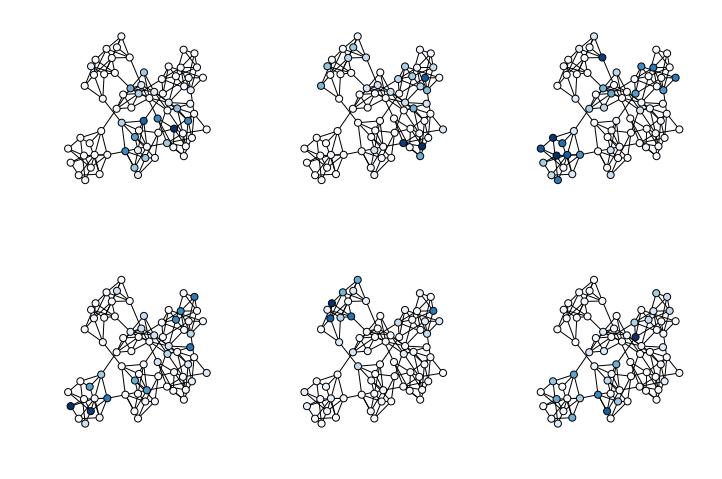

In [105]:
# Visualization of the NMF components
plt.figure(1,figsize=(12,8))
pos=nx.graphviz_layout(PPI,prog="neato")
for cn in range(0,6):
    node_color=NMFComponents[cn]
    plt.subplot(2, 3, cn+1)
    nx.draw(PPI,pos,with_labels=False,node_size=50,node_color=node_color,cmap = plt.cm.Blues)
plt.show()

In [106]:
# Sparse Non-Negative Matrix Factorization (NMF)
model = ProjectedGradientNMF(n_components=pathwaysNum, init='random', random_state=0, sparseness='data')
model.fit(np.matrix([extractMutationProfile(patient) for patient in patients]))
SparseNMFComponents=model.components_

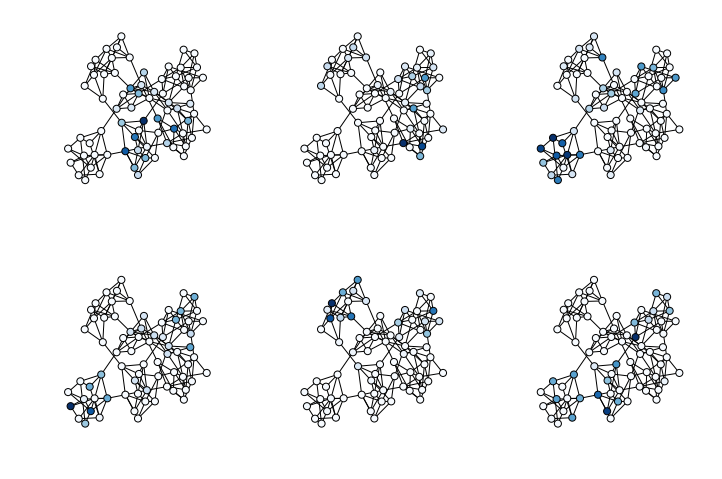

In [107]:
# Visualization of the sparse NMF components
plt.figure(1,figsize=(12,8))
pos=nx.graphviz_layout(PPI,prog="neato")
for cn in range(0,6):
    node_color=SparseNMFComponents[cn]
    plt.subplot(2, 3, cn+1)
    nx.draw(PPI,pos,with_labels=False,node_size=50,node_color=node_color,cmap = plt.cm.Blues)
plt.show()

# Adaptated GNMF from Scikit-Learn NMF
[Link to Scikit-Learn source code](https://github.com/scikit-learn/scikit-learn/blob/bb39b49/sklearn/decomposition/nmf.py#L584)

In [108]:
## Reuse scikit-learn functions
import scipy.sparse as sp
from sklearn.utils import atleast2d_or_csr, check_random_state, check_arrays
from sklearn.utils.extmath import randomized_svd, safe_sparse_dot

def check_non_negative(X, whom):
    X = X.data if sp.issparse(X) else X
    if (X < 0).any():
        raise ValueError("Negative values in data passed to %s" % whom)

def _sparseness(x):
    """Hoyer's measure of sparsity for a vector"""
    sqrt_n = np.sqrt(len(x))
    return (sqrt_n - np.linalg.norm(x, 1) / norm(x)) / (sqrt_n - 1)

def safe_vstack(Xs):
    if any(sp.issparse(X) for X in Xs):
        return sp.vstack(Xs)
    else:
        return np.vstack(Xs)

def NBS_init(X,n_components,init=None):
        n_samples, n_features = X.shape
        if init is None:
            if n_components < n_features:
                init = 'nndsvd'
            else:
                init = 'random'


        if init == 'nndsvd':
            W, H = _initialize_nmf(X, n_components)
        elif init == "random":
            rng = check_random_state(random_state)
            W = rng.randn(n_samples, n_components)
            # we do not write np.abs(W, out=W) to stay compatible with
            # numpy 1.5 and earlier where the 'out' keyword is not
            # supported as a kwarg on ufuncs
            np.abs(W, W)
            H = rng.randn(n_components, n_features)
            np.abs(H, H)
        else:
            raise ValueError(
                'Invalid init parameter: got %r instead of one of %r' %
                (init, (None, 'nndsvd', 'nndsvda', 'nndsvdar', 'random')))
        return W, H

def _initialize_nmf(X, n_components, variant=None, eps=1e-6,
                    random_state=None):
    """NNDSVD algorithm for NMF initialization.

    Computes a good initial guess for the non-negative
    rank k matrix approximation for X: X = WH

    Parameters
    ----------

    X : array, [n_samples, n_features]
        The data matrix to be decomposed.

    n_components : array, [n_components, n_features]
        The number of components desired in the approximation.

    variant : None | 'a' | 'ar'
        The variant of the NNDSVD algorithm.
        Accepts None, 'a', 'ar'
        None: leaves the zero entries as zero
        'a': Fills the zero entries with the average of X
        'ar': Fills the zero entries with standard normal random variates.
        Default: None

    eps: float
        Truncate all values less then this in output to zero.

    random_state : numpy.RandomState | int, optional
        The generator used to fill in the zeros, when using variant='ar'
        Default: numpy.random

    Returns
    -------

    (W, H) :
        Initial guesses for solving X ~= WH such that
        the number of columns in W is n_components.

    Remarks
    -------

    This implements the algorithm described in
    C. Boutsidis, E. Gallopoulos: SVD based
    initialization: A head start for nonnegative
    matrix factorization - Pattern Recognition, 2008

    http://tinyurl.com/nndsvd
    """
    check_non_negative(X, "NMF initialization")
    if variant not in (None, 'a', 'ar'):
        raise ValueError("Invalid variant name")

    U, S, V = randomized_svd(X, n_components)
    W, H = np.zeros(U.shape), np.zeros(V.shape)

    # The leading singular triplet is non-negative
    # so it can be used as is for initialization.
    W[:, 0] = np.sqrt(S[0]) * np.abs(U[:, 0])
    H[0, :] = np.sqrt(S[0]) * np.abs(V[0, :])

    for j in range(1, n_components):
        x, y = U[:, j], V[j, :]

        # extract positive and negative parts of column vectors
        x_p, y_p = np.maximum(x, 0), np.maximum(y, 0)
        x_n, y_n = np.abs(np.minimum(x, 0)), np.abs(np.minimum(y, 0))

        # and their norms
        x_p_nrm, y_p_nrm = norm(x_p), norm(y_p)
        x_n_nrm, y_n_nrm = norm(x_n), norm(y_n)

        m_p, m_n = x_p_nrm * y_p_nrm, x_n_nrm * y_n_nrm

        # choose update
        if m_p > m_n:
            u = x_p / x_p_nrm
            v = y_p / y_p_nrm
            sigma = m_p
        else:
            u = x_n / x_n_nrm
            v = y_n / y_n_nrm
            sigma = m_n

        lbd = np.sqrt(S[j] * sigma)
        W[:, j] = lbd * u
        H[j, :] = lbd * v

    W[W < eps] = 0
    H[H < eps] = 0

    if variant == "a":
        avg = X.mean()
        W[W == 0] = avg
        H[H == 0] = avg
    elif variant == "ar":
        random_state = check_random_state(random_state)
        avg = X.mean()
        W[W == 0] = abs(avg * random_state.randn(len(W[W == 0])) / 100)
        H[H == 0] = abs(avg * random_state.randn(len(H[H == 0])) / 100)

    return W, H

In [109]:
# Adapted version of the NMF function to integrate graph-regularization
def GNMF(X,L,lambd=0,n_components=None,tol=1e-4,max_iter=200):      
        X = atleast2d_or_csr(X)
        check_non_negative(X, "NMF.fit")
        n_samples, n_features = X.shape
  
        if not n_components:
            n_components = n_features
        else:
            n_components = n_components
  
        W, H = NBS_init(X,n_components)
        
        eps=10e-14
        for n_iter in range(1, max_iter + 1):
            Lp = (abs(L)+L)/2
            Lm = (abs(L)-L)/2
                   
            h1=lambd*np.dot(H,Lm)+np.dot(W.T,(X+eps)/(np.dot(W,H)+eps))
            h2=lambd*np.dot(H,Lp)+np.dot(W.T,np.ones(shape(X)))
            H = multiply(H,(h1+eps)/(h2+eps))
            H[H<=0]=eps
            
            w1=np.dot((X+eps)/(np.dot(W,H)+eps),H.T)
            w2=np.dot(np.ones(shape(X)),H.T)
            W = multiply(W,(w1+eps)/(w2+eps))
            W[H<=0]=eps
            
            if not sp.issparse(X):
                reconstruction_err_ = norm(X - np.dot(W, H))
            else:
                norm2X = np.sum(X.data ** 2)  # Ok because X is CSR
                normWHT = np.trace(np.dot(np.dot(H.T, np.dot(W.T, W)), H))
                cross_prod = np.trace(np.dot((X * H.T).T, W))
                reconstruction_err_ = sqrt(norm2X + normWHT - 2. * cross_prod)
                    
            if reconstruction_err_<tol:
                warnings.warn("Tolerance error reached during fit")
                break
            
            if numpy.isnan(W).any() or numpy.isnan(H).any():
                warnings.warn("NaN values at "+ str(n_iter)+" Error="+str(reconstruction_err_))
                break
                              
            if n_iter == max_iter:
                warnings.warn("Iteration limit reached during fit")
  
        return np.squeeze(np.asarray(W)), np.squeeze(np.asarray(H))

In [114]:
# With graph structure
PPIAdjacencyMatrix=nx.to_numpy_matrix(PPI)
W,StratipyGNMFComponents = GNMF(np.matrix([extractMutationProfile(patient) for patient in patients]),PPIAdjacencyMatrix,0.5,n_components=pathwaysNum,tol=1e-4,max_iter=1000)

/Users/gdumas/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:46: UserWarning: Iteration limit reached during fit


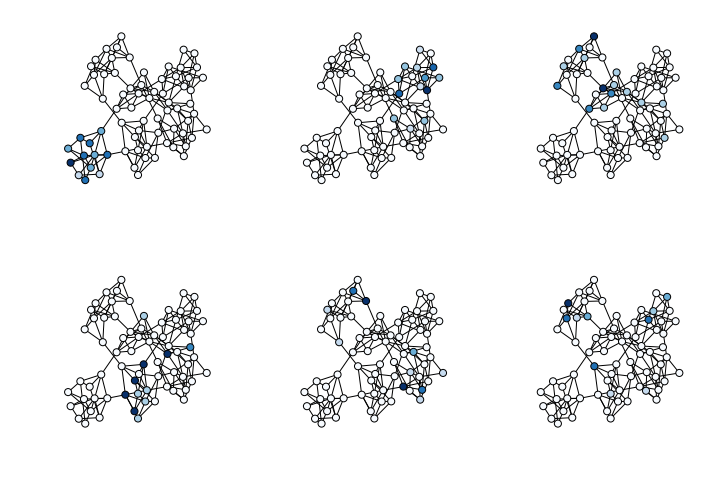

In [115]:
# Visualization of the GNMF components
plt.figure(1,figsize=(12,8))
pos=nx.graphviz_layout(PPI,prog="neato")
for cn in range(0,6):
    node_color=StratipyGNMFComponents[cn]
    plt.subplot(2, 3, cn+1)
    nx.draw(PPI,pos,with_labels=False,node_size=50,node_color=node_color,cmap = plt.cm.Blues)
plt.show()

In [116]:
# Without graph structure (lambda = 0)
W,StratipyNGNMFComponents = GNMF(np.matrix([extractMutationProfile(patient) for patient in patients]),PPIAdjacencyMatrix,0.,n_components=pathwaysNum,tol=1e-4,max_iter=1000)

/Users/gdumas/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:46: UserWarning: Iteration limit reached during fit


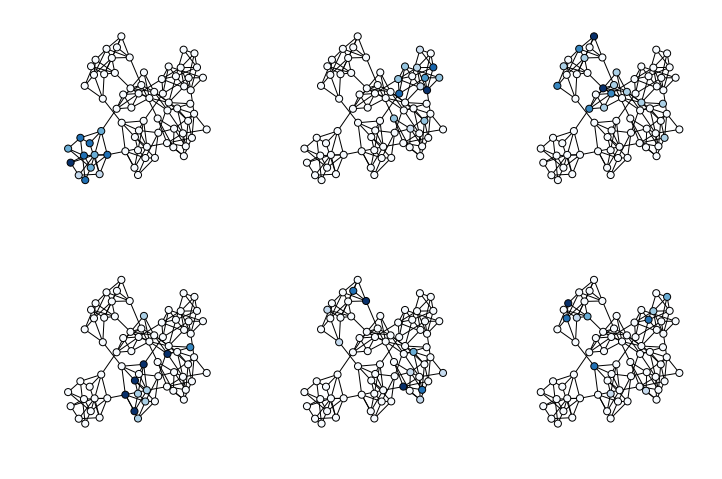

In [117]:
# Visualization of the GNMF components without graph structure
plt.figure(1,figsize=(12,8))
pos=nx.graphviz_layout(PPI,prog="neato")
for cn in range(0,6):
    node_color=StratipyNGNMFComponents[cn]
    plt.subplot(2, 3, cn+1)
    nx.draw(PPI,pos,with_labels=False,node_size=50,node_color=node_color,cmap = plt.cm.Blues)
plt.show()